In [13]:
import os
import pandas as pd
from pyspark.sql import SparkSession
import random


In [2]:
os.environ["JAVA_HOME"] = "/nix/store/8drvwqmcxh2rvasgr7visxrgfjxnd3an-openjdk-11.0.19+7"

spark = SparkSession.builder \
    .appName("SqlQuery") \
    .master("local[*]") \
    .getOrCreate()


In [20]:
users = ["alice@gmail.com", "bob@gmail.com", "carol@gmail.com", "dave@gmail.com", "eve@gmail.com"]
days = [20240501 + i for i in range(8)]

records = []
used_pairs = set()

while len(records) < 100:
    day = random.choice(days)
    from_user = random.choice(users)
    to_user = random.choice(users)
    if from_user != to_user and (day, from_user, to_user) not in used_pairs:
        used_pairs.add((day, from_user, to_user))
        records.append((day, from_user, len(records) + 1, to_user))

df_emails = pd.DataFrame(records, columns=["day", "from_user", "id", "to_user"])
df_emails
df_spark = spark.createDataFrame(df_emails)
df_spark.createOrReplaceTempView("google_gmail_emails")
df_spark.show()

/nix/store/ay67m3dhqwxnf3qna4xj3ywnknxya2k4-python3-3.10.14-env/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


+--------+---------------+---+---------------+
|     day|      from_user| id|        to_user|
+--------+---------------+---+---------------+
|20240501| dave@gmail.com|  1|alice@gmail.com|
|20240508|carol@gmail.com|  2|  bob@gmail.com|
|20240505|alice@gmail.com|  3|  bob@gmail.com|
|20240501|  bob@gmail.com|  4| dave@gmail.com|
|20240507|carol@gmail.com|  5|  eve@gmail.com|
|20240504|carol@gmail.com|  6| dave@gmail.com|
|20240502|  eve@gmail.com|  7|alice@gmail.com|
|20240503|alice@gmail.com|  8|  bob@gmail.com|
|20240507|  eve@gmail.com|  9| dave@gmail.com|
|20240501|carol@gmail.com| 10| dave@gmail.com|
|20240503|  bob@gmail.com| 11| dave@gmail.com|
|20240505| dave@gmail.com| 12|carol@gmail.com|
|20240503|  eve@gmail.com| 13| dave@gmail.com|
|20240506|  eve@gmail.com| 14|  bob@gmail.com|
|20240501|alice@gmail.com| 15|carol@gmail.com|
|20240504|  eve@gmail.com| 16|carol@gmail.com|
|20240505|carol@gmail.com| 17|  eve@gmail.com|
|20240503|carol@gmail.com| 18|  bob@gmail.com|
|20240504| da

# Problem statement: 
Find the email activity rank for each user. Email activity rank is defined by the total number of emails sent. The user with the highest number of emails sent will have a rank of 1, and so on. Output the user, total emails, and their activity rank. • Order records first by the total emails in descending order. • Then, sort users with the same number of emails in alphabetical order by their username. • In your rankings, return a unique value (i.e., a unique rank) even if multiple users have the same number of emails.
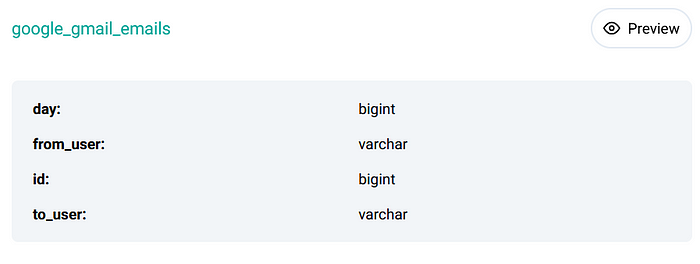

In [18]:
result = spark.sql("""
SELECT 

from_user, 
COUNT(*) as TotalEmails, 
DENSE_RANK() OVER (ORDER BY COUNT(id) DESC,from_user) as rank 

FROM 

google_gmail_emails

GROUP BY 

from_user

ORDER BY 

TotalEmails DESC,
from_user ASC
""")
result.show()

25/05/06 12:48:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/06 12:48:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/06 12:48:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/06 12:48:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/06 12:48:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/06 12:48:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/06 1

+---------------+-----------+----+
|      from_user|TotalEmails|rank|
+---------------+-----------+----+
|  bob@gmail.com|         22|   1|
|carol@gmail.com|         21|   2|
|alice@gmail.com|         20|   3|
| dave@gmail.com|         19|   4|
|  eve@gmail.com|         18|   5|
+---------------+-----------+----+

